In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from time import time
from pathlib import Path
from tqdm.notebook import tqdm
import data_tools.graphs as gt
from hetnet_ml.extractor import MatrixFormattedGraph, piecewise_extraction

/home/rogertu/projects/MechRepoNet/mrn_venv/lib/python3.8/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
next(filter(lambda d: d.startswith('13c') and d.endswith('10to1'), os.listdir(Path('../2_pipeline/test_ratio').resolve())))

'13c_Model_Prep_Hyperparam_tuning_10to1'

In [3]:
os.listdir(os.path.join(Path('../2_pipeline/'),'test_ratio'))

['13c_Model_Prep_Hyperparam_tuning_1000to1',
 '13c_Model_Prep_Hyperparam_tuning_10to1']

In [4]:
load_dir = Path('../2_pipeline').resolve()

hyp_name = next(filter(lambda d: d.startswith('13c') and d.endswith('10to1'), os.listdir(os.path.join(load_dir,'test_ratio'))))
prep_name = next(filter(lambda d: d.startswith('13b'), os.listdir(load_dir)))
nw_name = next(filter(lambda d: d.startswith('13a'), os.listdir(load_dir)))

nw_dir = load_dir.joinpath(nw_name, 'out')
prep_dir = load_dir.joinpath(prep_name, 'out')
hyp_dir = load_dir.joinpath('test_ratio',hyp_name, 'out')

In [5]:
this_name = '14a_Model_Eval_10fold_CV_10to1'
out_dir = load_dir.joinpath(this_name, 'out')
out_dir.mkdir(parents=True, exist_ok=True)

In [6]:
%%time
nodes = gt.remove_colons(pd.read_csv(nw_dir.joinpath('nodes.csv'), dtype=str))
edges = gt.remove_colons(pd.read_csv(nw_dir.joinpath('edges.csv'), dtype=str))

print('{:,} Nodes'.format(len(nodes)))
print('{:,} Edges'.format(len(edges)))

250,035 Nodes
9,638,511 Edges
CPU times: user 14.4 s, sys: 3.58 s, total: 18 s
Wall time: 23.8 s


In [7]:
best_param = pickle.load(open(hyp_dir.joinpath('best_param.pkl'), 'rb'))
best_param

{'C': 0.13912362433541536,
 'l1_ratio': 0.5489902557005799,
 'w': 0.8604135949722}

## Routine for extracting information

In [8]:
%%time
mg = MatrixFormattedGraph(nodes, edges, 'ChemicalSubstance', 'Disease', max_length=4, w=best_param['w'], n_jobs=32)

Processing node and edge data...
Initializing metagraph...
Generating adjacency matrices...


100%|███████████████████████████████████████████████████████████████████████████████████| 68/68 [00:45<00:00,  1.49it/s]



Determining degrees for each node and metaedge


100%|███████████████████████████████████████████████████████████████████████████████████| 68/68 [00:24<00:00,  2.83it/s]



Weighting matrices by degree with dampening factor 0.8604135949722...


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 119.14it/s]


CPU times: user 31.6 s, sys: 10.3 s, total: 41.9 s
Wall time: 1min 53s


#### Right away lets get the true positives as we will need them later

In [9]:
pos_tups = (mg.edge_df.query('type == "treats_CtD"')[['start_id', 'end_id']]
                      .apply(tuple, axis=1)
                      .tolist())
pos_tups = set(pos_tups)

## Ideal Training Subset

Ideally we need all compounds and diseases associated with training positives, as well as some negatives.

In [10]:
float_size = 32 # bits
bits_per_gb = 8589934592

def print_mem_info(n_comp, n_dis, n_mps):
    print("{:,} Compounds * {:,} Diseases = {:,} C-D Pairs".format(n_comp, n_dis,
                                                                   n_comp * n_dis))
    print("{:,} C-D Pairs * {:,} Metapaths = {:,} Matrix Values".format(n_comp * n_dis,
                                                                    n_mps, 
                                                                    n_comp * n_dis * n_mps))

    print('{:1,.1f} GB of matrix values'.format(n_comp * n_dis * n_mps * float_size / (bits_per_gb)))
    
    print('{:1,.3f} GB per metapath'.format(n_comp * n_dis * float_size / (bits_per_gb)))

In [11]:
ref_c = nodes.dropna(subset=['source'])['id'].tolist()

In [12]:
neg_frac = 0.1
rs = 20200201


treat_comps = set(edges.query('type == "treats_CtD"')['start_id'])
# Sample the negatives and subsample, but not Reframe negatvies... keep them as 'Unknown'
keep_comps = set(nodes.query('id not in @treat_comps and id not in @ref_c and label == "ChemicalSubstance"')
                                    .sample(frac=neg_frac, random_state=rs)['id'])
# Merge togetehr
keep_comps = sorted(list(keep_comps | treat_comps))

treat_dis = set(edges.query('type == "treats_CtD"')['end_id'])
# Sample the negatives 
keep_dis = set(nodes.query('label == "Disease" and id not in @treat_dis')
                    .sample(frac=neg_frac, random_state=rs+1)['id'])
# Merge together
keep_dis = sorted(list(keep_dis | treat_dis))

In [13]:
mp_counts = pd.read_csv(prep_dir.joinpath('all_mp_counts.csv'))
mp_qr = mp_counts.query('subset == "all_pairs" and sim_mp == False and pair_count > 0')
mp_to_extract = mp_qr['mp'].tolist()

mech_mps = pd.read_csv('../0_data/manual/mech_mps.txt', header=None)[0].values
dmdb_feat = mp_counts.query('mp in @mech_mps and subset == "all_pairs" and pair_count > 0')['mp'].unique().tolist()
len(dmdb_feat)

55

In [14]:
print_mem_info(len(keep_comps), len(keep_dis), len(mp_to_extract))

11,962 Compounds * 6,190 Diseases = 74,044,780 C-D Pairs
74,044,780 C-D Pairs * 7,012 Metapaths = 519,201,997,360 Matrix Values
1,934.2 GB of matrix values
0.276 GB per metapath


In [15]:
def display_time(seconds):
    result = []
    
    intervals = (
    ('weeks', 604800),  # 60 * 60 * 24 * 7
    ('days', 86400),    # 60 * 60 * 24
    ('hours', 3600),    # 60 * 60
    ('minutes', 60),
    ('seconds', 1),
    )


    for name, count in intervals:
        value = seconds // count
        if value:
            seconds -= value * count
            if value == 1:
                name = name.rstrip('s')
            result.append("{:1.0f} {}".format(value, name))
    return ', '.join(result)

In [16]:
def sort_mps_for_pw_extraction(n_big_calcs, big_per_block):
    
    big_mp = mp_qr.sort_values('frac', ascending=False).head(n_big_calcs)['mp'].tolist()
    other_mp = list(set(mp_to_extract) - set(big_mp))

    block_size = len(other_mp) // (len(big_mp) // big_per_block)
    n_blocks = ((len(big_mp) + len(other_mp)) // block_size)

    out = []
    for i in range(n_blocks):
        for j in range(big_per_block):
            idx = i*big_per_block + j
            out.append(big_mp[idx])
        out += other_mp[i*block_size:(i+1)*block_size] 
        
    out += list(set(other_mp) - set(out))    
    
    return out, block_size

In [17]:
mp_to_extract, block_size = sort_mps_for_pw_extraction(30, 5)

In [18]:
len(mp_to_extract), block_size

(7012, 1163)

# Build the CV Pipeline

Bring in the functions needed for quick processing

In [19]:
from scipy.sparse import issparse, csc_matrix, csr_matrix

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel
from sklearn.metrics import roc_auc_score, average_precision_score

from xgboost import XGBClassifier

In [20]:
def get_target_values(train_pairs, test_pairs):
    y_train = []
    for row in tqdm(train_pairs.itertuples(), total=len(train_pairs)):
        # pos_tups defined several cells above
        if set([(row.chemicalsubstance_id, row.disease_id)]) & pos_tups:
            y_train.append(1)
        else:
            y_train.append(0)

    y_test = []
    for row in tqdm(test_pairs.itertuples(), total=len(test_pairs)):
        # pos_tups defined several cells above
        if set([(row.chemicalsubstance_id, row.disease_id)]) & pos_tups:
            y_test.append(1)
        else:
            y_test.append(0)
            
    return np.array(y_train), np.array(y_test)

In [21]:
def cor_selector(X, y, feature_names, num_feats):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in range(X.shape[1]):
        if issparse(X):
            x = X[:, i].A.reshape(len(y))
        else:
            x = X[:, i]
        cor = np.corrcoef(x, y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = np.array(feature_names)[np.argsort(np.abs(cor_list))[-num_feats:].tolist()].tolist()    
    # feature selection? 0 for not select, 1 for select
    return [True if i in cor_feature else False for i in feature_names]

def chi2_selector(X, y, num_feats):
    this_selector = SelectKBest(chi2, k=num_feats)
    this_selector.fit(X, y)
    return this_selector.get_support()

def rfe_selector(X, y, num_feats, random_state=None):
    this_selector = RFE(estimator=LogisticRegression(C=.1, solver='liblinear', random_state=random_state), 
                        n_features_to_select=num_feats, step=.2, verbose=5)
    this_selector.fit(X, y)
    return this_selector.get_support()

def embeded_lr_selector(X, y, num_feats, random_state=None):
    this_selector = SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear', random_state=random_state), 
                                    max_features=num_feats)
    this_selector.fit(X, y)

    return this_selector.get_support()

def embeded_rf_selector(X, y, num_feats, n_jobs, random_state=None):
    rfc = RandomForestClassifier(n_estimators=100, max_depth=50, n_jobs=n_jobs, random_state=random_state)
    this_selector = SelectFromModel(rfc, max_features=num_feats)
    this_selector.fit(X, y)
    return this_selector.get_support()

def embeded_xgb_selector(X, y, num_feats, n_jobs=1, random_state=None):
    # XGBoost takes 0 as default random state
    if random_state is None:
        random_state = 0
    # Paramaters optimized for speed, rather than accuracy (as we have 5 other estimators also providing votes)
    xgbc = XGBClassifier(max_depth=5, n_estimators=200, learning_rate=.16, min_child_weight=1, colsample_bytree=.8,
                         n_jobs=n_jobs, random_state=random_state)
    this_selector = SelectFromModel(xgbc, max_features=num_feats)
    this_selector.fit(X, y)
    return this_selector.get_support()


class FeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, num_features=100, min_selections=4, n_jobs=1, feature_names=None, always_keep=None,
                 random_state=None):
        self.num_features = num_features
        self.min_selections = min_selections
        self.n_jobs = n_jobs
        self.feature_names = feature_names
        self.always_keep = always_keep
        self.random_state = random_state
        
    def fit(self, X, y=None):
                
        X_norm = MaxAbsScaler().fit_transform(X)
        if issparse(X):
            if type(X) != csc_matrix:
                X = X.tocsc()
            X_norm = X_norm.tocsc()
        
        print('Running Cor')
        cor_support = cor_selector(X, y, self.feature_names, self.num_features)
        print('Running Chi2')
        chi_support = chi2_selector(X_norm, y, self.num_features)
        print('Running RFE')
        rfe_support = rfe_selector(X_norm, y, self.num_features, self.random_state)
        print('Running LR')
        embeded_lr_support = embeded_lr_selector(X_norm, y, self.num_features, self.random_state)
        print('Running RF')
        embeded_rf_support = embeded_rf_selector(X, y, self.num_features, 
                                                 n_jobs=self.n_jobs, random_state=self.random_state)
        print('Running XG')
        embeded_xgb_support = embeded_xgb_selector(X, y, self.num_features, 
                                                   n_jobs=self.n_jobs, random_state=self.random_state)
        
        feature_selection_df = pd.DataFrame({'feature':self.feature_names, 'pearson':cor_support, 'chi_2':chi_support, 
                                             'rfe':rfe_support, 'logistics':embeded_lr_support,
                                             'random_forest':embeded_rf_support, 'xgboost':embeded_xgb_support})  

        feature_selection_df['total'] = np.sum(feature_selection_df, axis=1)
        self.feature_selection_df_ = feature_selection_df
        
        keep_features = feature_selection_df.query('total >= {}'.format(self.min_selections))['feature'].tolist()
        
        # Keep the features that we always want (e.g. domain expertise)
        if self.always_keep is not None:
            keep_features.extend(self.always_keep)
        
        self.keep_features_ = [f for f in self.feature_names if f in keep_features]
        
        return self
    
    def transform(self, X, y=None):
        
        if issparse(X) and type(X) != csc_matrix:
            X = X.tocsc()
        return X[:, [i for i, f in enumerate(self.feature_names) if f in self.keep_features_]]

In [22]:
class MeanScaledArcsinhTransformer(TransformerMixin):
        
    def fit(self, X, y=None):
        if issparse(X):
            self.initial_mean_ = X.tocoo().tocsc().mean(axis=0).A[0]
        else:
            self.initial_mean_ = X.mean(axis=0)

        # If input was DataFrame, Converts resultant series to ndarray
        try:
            self.initial_mean_ = self.initial_mean_.values
        except:
            pass
        
        # If inital mean == 0, likely all values were zero
        # this prevents issues later.
        self.initial_mean_[np.where(self.initial_mean_ == 0.0)] = 1
        
        return self

    def transform(self, X, y=None):
        if issparse(X):
            return np.arcsinh(X.tocoo().tocsc().multiply(self.initial_mean_**-1)).tocsc()
        return np.arcsinh(X / self.initial_mean_)


In [23]:
def sparse_std(data, axis=1):                                                                              
    """take the standard deviation of a sparse matrix"""                  

    def get_vec_std(vec):                                                                                       
        return vec.A.std(ddof=1)                                                                                

    stds = []        
    
    # ensure the correct matrix type for easy row or column subsetting
    if axis==1 and type(data) != csc_matrix:
        data = data.tocoo().tocsc()
    if axis==0 and type(data) != csr_matrix:
        data = data.tocoo().tocsr()
    
    # Get the std for each vector along the given axis individually
    for i in range(data.shape[axis]):                                                                              
        if axis==1:
            stds.append(get_vec_std(data.getcol(i)))       
        elif axis==0:
            stds.append(get_vec_std(data.getrow(i)))       
        
    return np.array(stds)
    

def get_model_coefs(model, X, f_names):                                                                                 
    """Helper Function to quickly return the model coefs and correspoding fetaure names"""                              
                                                                                                                        
    # Ensure we have a numpy array for the features                                                                     
    if type(X) == pd.DataFrame:                                                                                         
        X = X.values
        
                                                                                                                        
    # Grab the coeffiencts                                                                                              
    coef = model.coef_                                                                                                  
    # Some models return a double dimension array, others only a single                                                 
    if len(coef) != len(f_names):                                                                                       
        coef = coef[0]                                                                                                  
                                                                                                                        
    # insert the intercept                                                                                              
    coef = np.insert(coef, 0, model.intercept_)                                                                         
    names = np.insert(f_names, 0, 'intercept')                                                                          
                                                                                                                        
    # Calculate z-score scaled coefficients based on the features                                                       
    if issparse(X):
        if type(X) != csc_matrix:
            X = X.tocoo().tocsc()
        z_intercept = coef[0] + sum(coef[1:] * X.mean(axis=0).A[0])
        z_coef = coef[1:] * sparse_std(X, axis=1)
        z_coef = np.insert(z_coef, 0, z_intercept)
    else:
        z_intercept = coef[0] + sum(coef[1:] * X.mean(axis=0))                                                              
        z_coef = coef[1:] * X.std(axis=0)                                                                                   
        z_coef = np.insert(z_coef, 0, z_intercept)                                                                          
                                                                                                                        
    # Return                                                                                                            
    return pd.DataFrame([names, coef, z_coef]).T.rename(columns={0:'feature', 1:'coef', 2:'zcoef'})    

In [24]:
fs = pickle.load(open(hyp_dir.joinpath('feature_selector.pkl'), 'rb'))

In [25]:
mp_to_extract = list(set(fs.keep_features_) | set(dmdb_feat))

In [26]:
enet_params = {k: v for k, v in best_param.items() if k != 'w'}

post_extraction_pipeline = Pipeline(
    [('transformer', MeanScaledArcsinhTransformer()),
     #('feature_selection', FeatureSelector(num_features=500, min_selections=3, n_jobs=30,
     #                                      feature_names=mp_to_extract, always_keep=dmdb_feat)),
     ('maxabs_scale', MaxAbsScaler()),
     ('e_net', LogisticRegression(penalty='elasticnet', solver='saga', max_iter=500, **enet_params))], verbose=True)

In [27]:
# Get our compounds as ndarrays for easy indexing with sklearns StratifiedKFold
keep_comps = np.array(keep_comps)

In [28]:
print(keep_comps[:10])
print(keep_comps[-10:])

['CHEBI:100' 'CHEBI:100147' 'CHEBI:100148' 'CHEBI:100194' 'CHEBI:10023'
 'CHEBI:100241' 'CHEBI:100246' 'CHEBI:10033' 'CHEBI:10034' 'CHEBI:10036']
['WD:Q72496854' 'WD:Q72498509' 'WD:Q72499475' 'WD:Q72503697'
 'WD:Q72506824' 'WD:Q72506931' 'WD:Q72507054' 'WD:Q72507066'
 'WD:Q72507082' 'WD:Q72510490']


In [29]:
# Randomize the compounds
np.random.seed(20200221)
np.random.shuffle(keep_comps)
print(keep_comps[:10])
print(keep_comps[-10:])

['IKEY:HPXIKMBHOXLFOR-LICLKQGHSA-N' 'CHEBI:92490' 'CHEBI:86557'
 'IKEY:CYJWWQALTIKOAG-FLORRLIPSA-N' 'CHEBI:15920' 'MESH:C497332'
 'IKEY:JSKFWUPVIZYJMR-UDOAKELVSA-N' 'MESH:C539419' 'CHEBI:91337'
 'MESH:D012676']
['MESH:C057058' 'IKEY:YWXYYJSYQOXTPL-JGWLITMVSA-N' 'WD:Q72480354'
 'CHEBI:16464' 'MESH:C555559' 'IKEY:OWBFCJROIKNMGD-BQYQJAHWSA-N'
 'MESH:C111148' 'MESH:D004876' 'CHEBI:127235' 'CHEBI:68845']


In [30]:
# Need to know how to properly stratify the split
is_treat_comp = np.array([1 if c in treat_comps else 0 for c in keep_comps])

In [31]:
%%time
skf = StratifiedKFold(10)

for i, (train, test) in enumerate(skf.split(keep_comps, is_treat_comp)):
    
    start = time()
    print('Beginning Fold: {}'.format(i))
    
    # Segregate the training and testing compounds
    train_comps = keep_comps[train]
    test_comps = keep_comps[test]
   
    # Blind the model to treating compounds in the test set.
    remove_edges = mg.edge_df.query('type == "treats_CtD" and start_id in @test_comps')
    print('Removing {:,} Compound - TREATS - Disease edges.\n{:,} remain for training.'.format(
          len(remove_edges), len(mg.edge_df.query('type == "treats_CtD" and start_id not in @test_comps'))))
    ## Need the edges reset to their original values before removing them
    if i != 0:
        mg.reset_edges()
    mg.remove_edges(remove_edges)

    (pairs, out_mp), dwpc = mg.extract_dwpc(metapaths=mp_to_extract, start_nodes=keep_comps, end_nodes=keep_dis, 
                       return_sparse=True, sparse_df=False, verbose=True, n_jobs=30)

    #     (pairs, feats), dwpc = piecewise_extraction(function=mg.extract_dwpc, 
    #                            to_split='metapaths', block_size=block_size,
    #                            axis=1,
    #                            metapaths=mp_to_extract, 
    #                            start_nodes=list(keep_comps), 
    #                            end_nodes=list(keep_dis),
    #                            return_sparse=True,
    #                            sparse_df=False,
    #                            n_jobs=30)


    # Get the indicies for training and testing Compound-Disease Pairs
    train_pairs = pairs.query('chemicalsubstance_id in @train_comps')
    test_pairs = pairs.query('chemicalsubstance_id in @test_comps').copy()

    train_idx = train_pairs.index.tolist()
    test_idx = test_pairs.index.tolist()

    # Split the Training and Testing
    print('Dividing training and test sets...')
    dwpc = dwpc.tocoo().tocsr()

    X_train = dwpc[train_idx, :]
    X_test = dwpc[test_idx, :]

    
    print('Getting Target Values')
    y_train, y_test = get_target_values(train_pairs, test_pairs)
    
    print('Subseting Training Examples')
    # For training, Remove the values with zeros across all metapaths,
    # then take a subsample of 100x the postitives in negatives..
    train_subset = train_pairs.reset_index(drop=True)
    train_subset['status'] = y_train

    # Get the training examples that have metapaths
    nz_index = train_subset[X_train.getnnz(1)>0].index

    # have the number of postivies to get 100x this for the negatives.
    n_pos = train_subset['status'].sum()

    # Sample the nonzero negative examples at a rate of 100x the positive samples
    neg_index = train_subset.loc[nz_index].query('status == 0').sample(n=10*n_pos, random_state=rs+10+i).sort_index().index

    # and of course take the training postivies
    pos_index = train_subset.query('status == 1').index

    # Union the two
    final_train_index = pos_index.union(neg_index)
    
    
    # Fit the model and get results
    print('Training Model')
    post_extraction_pipeline.fit(X_train[final_train_index, :], y_train[final_train_index])
    y_test_proba = post_extraction_pipeline.predict_proba(X_test)[:, 1]
    
    # Get metrics
    roc_auc = roc_auc_score(y_test, y_test_proba)
    avg_prec = average_precision_score(y_test, y_test_proba)
    print('AUROC: {:1.4f}'.format(roc_auc))
    print('AUPR: {:1.4f}'.format(avg_prec))
    
    # Prep results for saving
    test_pairs['status'] = y_test
    test_pairs['proba'] = y_test_proba
    
    coef = get_model_coefs(post_extraction_pipeline[-1], X_train[final_train_index, :], 
                           mp_to_extract).sort_values('coef', ascending=False)
    
    # Save results and model
    test_pairs.to_csv(out_dir.joinpath('results_fold_{}.csv'.format(i)), index=False)
    coef.to_csv(out_dir.joinpath('coef_fold_{}.csv'.format(i)), index=False)
    pickle.dump(post_extraction_pipeline, open(out_dir.joinpath('model_fold_{}.pkl'.format(i)), 'wb'))
    
    print('Fold {} took: '.format(i) + display_time(time() - start))
    print('\n\n')

Beginning Fold: 0
Removing 4,682 Compound - TREATS - Disease edges.
51,352 remain for training.


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 49.13it/s]


Preparing function arguments...
Calculating DWPCs...


100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [04:28<00:00,  1.52s/it]



Reshaping Result Matrices...


100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [01:04<00:00,  2.73it/s]


Stacking columns...
Dividing training and test sets...
Getting Target Values


  0%|          | 0/66635350 [00:00<?, ?it/s]

  0%|          | 0/7409430 [00:01<?, ?it/s]

Subseting Training Examples
Training Model
[Pipeline] ....... (step 1 of 3) Processing transformer, total=   2.5s
[Pipeline] ...... (step 2 of 3) Processing maxabs_scale, total=   0.2s
[Pipeline] ............. (step 3 of 3) Processing e_net, total=  12.6s
AUROC: 0.7703
AUPR: 0.0233
Fold 0 took: 9 minutes, 44 seconds



Beginning Fold: 1
Removing 5,313 Compound - TREATS - Disease edges.
50,721 remain for training.


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.81it/s]


Preparing function arguments...
Calculating DWPCs...


100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [03:47<00:00,  1.28s/it]



Reshaping Result Matrices...


100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [01:05<00:00,  2.71it/s]


Stacking columns...
Dividing training and test sets...
Getting Target Values


  0%|          | 0/66635350 [00:00<?, ?it/s]

  0%|          | 0/7409430 [00:00<?, ?it/s]

Subseting Training Examples
Training Model
[Pipeline] ....... (step 1 of 3) Processing transformer, total=   2.4s
[Pipeline] ...... (step 2 of 3) Processing maxabs_scale, total=   0.2s
[Pipeline] ............. (step 3 of 3) Processing e_net, total=  12.5s
AUROC: 0.7920
AUPR: 0.0241
Fold 1 took: 9 minutes, 25 seconds



Beginning Fold: 2
Removing 6,514 Compound - TREATS - Disease edges.
49,520 remain for training.


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.45it/s]


Preparing function arguments...
Calculating DWPCs...


100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [03:49<00:00,  1.29s/it]



Reshaping Result Matrices...


100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [01:05<00:00,  2.68it/s]


Stacking columns...
Dividing training and test sets...
Getting Target Values


  0%|          | 0/66641540 [00:00<?, ?it/s]

  0%|          | 0/7403240 [00:00<?, ?it/s]

Subseting Training Examples
Training Model
[Pipeline] ....... (step 1 of 3) Processing transformer, total=   2.4s
[Pipeline] ...... (step 2 of 3) Processing maxabs_scale, total=   0.2s
[Pipeline] ............. (step 3 of 3) Processing e_net, total=  12.9s
AUROC: 0.7952
AUPR: 0.0239
Fold 2 took: 9 minutes, 28 seconds



Beginning Fold: 3
Removing 5,265 Compound - TREATS - Disease edges.
50,769 remain for training.


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 54.43it/s]


Preparing function arguments...
Calculating DWPCs...


100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [03:27<00:00,  1.17s/it]



Reshaping Result Matrices...


100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [01:05<00:00,  2.69it/s]


Stacking columns...
Dividing training and test sets...
Getting Target Values


  0%|          | 0/66641540 [00:00<?, ?it/s]

  0%|          | 0/7403240 [00:00<?, ?it/s]

Subseting Training Examples
Training Model
[Pipeline] ....... (step 1 of 3) Processing transformer, total=   2.5s
[Pipeline] ...... (step 2 of 3) Processing maxabs_scale, total=   0.2s
[Pipeline] ............. (step 3 of 3) Processing e_net, total=  13.0s
AUROC: 0.8187
AUPR: 0.0338
Fold 3 took: 9 minutes, 12 seconds



Beginning Fold: 4
Removing 5,623 Compound - TREATS - Disease edges.
50,411 remain for training.


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 49.70it/s]


Preparing function arguments...
Calculating DWPCs...


100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [03:16<00:00,  1.11s/it]



Reshaping Result Matrices...


100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [01:07<00:00,  2.62it/s]


Stacking columns...
Dividing training and test sets...
Getting Target Values


  0%|          | 0/66641540 [00:00<?, ?it/s]

  0%|          | 0/7403240 [00:00<?, ?it/s]

Subseting Training Examples
Training Model
[Pipeline] ....... (step 1 of 3) Processing transformer, total=   2.4s
[Pipeline] ...... (step 2 of 3) Processing maxabs_scale, total=   0.2s
[Pipeline] ............. (step 3 of 3) Processing e_net, total=  11.1s
AUROC: 0.8111
AUPR: 0.0320
Fold 4 took: 9 minutes, 1 second



Beginning Fold: 5
Removing 5,892 Compound - TREATS - Disease edges.
50,142 remain for training.


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.49it/s]


Preparing function arguments...
Calculating DWPCs...


100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [03:36<00:00,  1.22s/it]



Reshaping Result Matrices...


100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [01:06<00:00,  2.65it/s]


Stacking columns...
Dividing training and test sets...
Getting Target Values


  0%|          | 0/66641540 [00:00<?, ?it/s]

  0%|          | 0/7403240 [00:00<?, ?it/s]

Subseting Training Examples
Training Model
[Pipeline] ....... (step 1 of 3) Processing transformer, total=   2.4s
[Pipeline] ...... (step 2 of 3) Processing maxabs_scale, total=   0.2s
[Pipeline] ............. (step 3 of 3) Processing e_net, total=  12.2s
AUROC: 0.7716
AUPR: 0.0223
Fold 5 took: 9 minutes, 24 seconds



Beginning Fold: 6
Removing 6,596 Compound - TREATS - Disease edges.
49,438 remain for training.


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.41it/s]


Preparing function arguments...
Calculating DWPCs...


100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [03:22<00:00,  1.15s/it]



Reshaping Result Matrices...


100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [01:05<00:00,  2.68it/s]


Stacking columns...
Dividing training and test sets...
Getting Target Values


  0%|          | 0/66641540 [00:00<?, ?it/s]

  0%|          | 0/7403240 [00:00<?, ?it/s]

Subseting Training Examples
Training Model
[Pipeline] ....... (step 1 of 3) Processing transformer, total=   2.2s
[Pipeline] ...... (step 2 of 3) Processing maxabs_scale, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing e_net, total=  11.6s
AUROC: 0.7879
AUPR: 0.0271
Fold 6 took: 9 minutes, 12 seconds



Beginning Fold: 7
Removing 4,830 Compound - TREATS - Disease edges.
51,204 remain for training.


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.22it/s]


Preparing function arguments...
Calculating DWPCs...


100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [03:32<00:00,  1.20s/it]



Reshaping Result Matrices...


100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [01:07<00:00,  2.63it/s]


Stacking columns...
Dividing training and test sets...
Getting Target Values


  0%|          | 0/66641540 [00:00<?, ?it/s]

  0%|          | 0/7403240 [00:00<?, ?it/s]

Subseting Training Examples
Training Model
[Pipeline] ....... (step 1 of 3) Processing transformer, total=   2.5s
[Pipeline] ...... (step 2 of 3) Processing maxabs_scale, total=   0.2s
[Pipeline] ............. (step 3 of 3) Processing e_net, total=  13.2s
AUROC: 0.7681
AUPR: 0.0186
Fold 7 took: 9 minutes, 29 seconds



Beginning Fold: 8
Removing 5,746 Compound - TREATS - Disease edges.
50,288 remain for training.


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 56.08it/s]


Preparing function arguments...
Calculating DWPCs...


100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [03:32<00:00,  1.20s/it]



Reshaping Result Matrices...


100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [01:07<00:00,  2.64it/s]


Stacking columns...
Dividing training and test sets...
Getting Target Values


  0%|          | 0/66641540 [00:00<?, ?it/s]

  0%|          | 0/7403240 [00:00<?, ?it/s]

Subseting Training Examples
Training Model
[Pipeline] ....... (step 1 of 3) Processing transformer, total=   2.3s
[Pipeline] ...... (step 2 of 3) Processing maxabs_scale, total=   0.2s
[Pipeline] ............. (step 3 of 3) Processing e_net, total=  11.9s
AUROC: 0.7398
AUPR: 0.0193
Fold 8 took: 9 minutes, 28 seconds



Beginning Fold: 9
Removing 5,573 Compound - TREATS - Disease edges.
50,461 remain for training.


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.38it/s]


Preparing function arguments...
Calculating DWPCs...


100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [03:25<00:00,  1.16s/it]



Reshaping Result Matrices...


100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [01:05<00:00,  2.71it/s]


Stacking columns...
Dividing training and test sets...
Getting Target Values


  0%|          | 0/66641540 [00:00<?, ?it/s]

  0%|          | 0/7403240 [00:00<?, ?it/s]

Subseting Training Examples
Training Model
[Pipeline] ....... (step 1 of 3) Processing transformer, total=   2.4s
[Pipeline] ...... (step 2 of 3) Processing maxabs_scale, total=   0.2s
[Pipeline] ............. (step 3 of 3) Processing e_net, total=  11.7s
AUROC: 0.8089
AUPR: 0.0253
Fold 9 took: 9 minutes, 21 seconds



CPU times: user 45min 44s, sys: 15min 4s, total: 1h 49s
Wall time: 1h 33min 48s


## Load back in all the results and plot

In [32]:
all_res = []

for f in sorted(out_dir.iterdir()):
    if f.stem.startswith('results_'):
        res = pd.read_csv(f)
        res['fold'] = int(f.stem.split('_')[-1])
        all_res.append(res)

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

from data_tools import plotting as pt

In [34]:
res.head(2)

,chemicalsubstance_id,disease_id,status,proba,fold
0,CHEBI:10101,DOID:0001816,0,0.044561,9
1,CHEBI:10101,DOID:0002116,0,0.069179,9


In [35]:
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

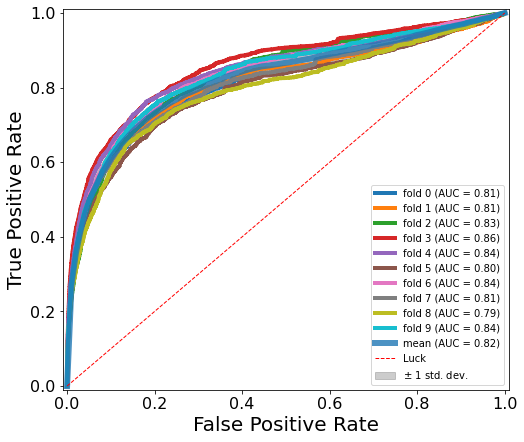

In [36]:
all_ys = []
all_y_trues = []

for i, res in enumerate(all_res):
    discon_res = res['proba'].value_counts().index[0]
    sub_res = res.query('proba != @discon_res')
    
    ys = sub_res['proba']
    y_trues = sub_res['status']
    
    all_ys.append(ys)
    all_y_trues.append(y_trues)

    pt.graph_single_roc(y_trues, ys, 'fold {}'.format(i))
    
pt.graph_mean_roc(all_y_trues, all_ys, 'mean')
pt.graph_roc_boilerplate('CV results - ROC')
plt.legend(loc=4)
plt.title('')
plt.savefig('10fold_roc.pdf');

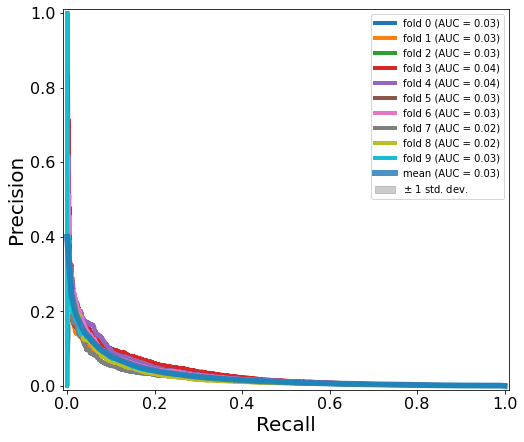

In [37]:
all_ys = []
all_y_trues = []

for i, res in enumerate(all_res):

    discon_res = res['proba'].value_counts().index[0]
    sub_res = res.query('proba != @discon_res')
    
    ys = sub_res['proba']
    y_trues = sub_res['status']
    
    all_ys.append(ys)
    all_y_trues.append(y_trues)
    
    pt.graph_single_prc(y_trues, ys, 'fold {}'.format(i))
    
pt.graph_mean_prc(all_y_trues, all_ys, 'mean')
pt.graph_prc_boilerplate('CV results - Precision Recall')
plt.title('')
plt.legend(loc=1)
plt.savefig('10fold_pr.pdf');